In [39]:
# Investment Portfolio Tracker - Jupyter Notebook
# Portfolio med startdato, indskud og daglig tracking
# Base Currency: DKK

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import warnings
from jinja2 import Environment, PackageLoader
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [40]:
# Cell 2: Configuration
TRANSACTIONS_FILE = 'transactions_thorleif.csv'
PORTFOLIO_CONFIG_FILE = 'portfolio_config_thorleif.csv'
BASE_CURRENCY = 'DKK'
BENCHMARK_TICKER = '^OMXC25GI'  # S&P 500 as default benchmark (can be changed to ^OMXC25 for Danish market)
RISK_FREE_RATE = 0.03  # 3% annual risk-free rate (adjust as needed)

print(f"Portfolio Configuration:")
print(f"  Transactions File: {TRANSACTIONS_FILE}")
print(f"  Portfolio Config File: {PORTFOLIO_CONFIG_FILE}")
print(f"  Base Currency: {BASE_CURRENCY}")
print(f"  Benchmark: {BENCHMARK_TICKER}")
print(f"  Risk-Free Rate: {RISK_FREE_RATE*100}%")

Portfolio Configuration:
  Transactions File: transactions_thorleif.csv
  Portfolio Config File: portfolio_config_thorleif.csv
  Base Currency: DKK
  Benchmark: ^OMXC25GI
  Risk-Free Rate: 3.0%


In [41]:
# Cell 3: Helper Functions
def load_portfolio_config():
    """Load portfolio configuration (start date and initial deposit)"""
    if os.path.exists(PORTFOLIO_CONFIG_FILE):
        df = pd.read_csv(PORTFOLIO_CONFIG_FILE)
        config = df.iloc[0].to_dict()
        print(f"✓ Loaded portfolio config: Start date: {config['start_date']}, Initial deposit: {config['initial_deposit']} {config['currency']}")
        return config
    else:
        print("ℹ No portfolio config found. Please create one using Cell 4.")
        return None

def save_portfolio_config(start_date, initial_deposit, currency=BASE_CURRENCY):
    """Save portfolio configuration"""
    config_df = pd.DataFrame({
        'start_date': [start_date],
        'initial_deposit': [initial_deposit],
        'currency': [currency]
    })
    config_df.to_csv(PORTFOLIO_CONFIG_FILE, index=False)
    print(f"✓ Portfolio config saved: Start {start_date}, Deposit {initial_deposit} {currency}")

def load_transactions():
    """Load transactions from CSV file"""
    if os.path.exists(TRANSACTIONS_FILE):
        df = pd.read_csv(TRANSACTIONS_FILE)
        print(f"✓ Loaded {len(df)} transactions from {TRANSACTIONS_FILE}")
        return df
    else:
        print(f"ℹ No existing transactions file. Creating new one.")
        return pd.DataFrame(columns=['date', 'ticker', 'action', 'quantity', 'price', 'currency', 'dividend_amount', 'transaction_fee', 'fx_fee'])

def save_transactions(df):
    """Save transactions to CSV file"""
    df.to_csv(TRANSACTIONS_FILE, index=False)
    print(f"✓ Saved {len(df)} transactions to {TRANSACTIONS_FILE}")

def get_exchange_rate(from_currency, to_currency=BASE_CURRENCY):
    """Get exchange rate from currency to base currency"""
    if from_currency == to_currency:
        return 1.0
    
    try:
        url = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"
        response = requests.get(url, timeout=5)
        data = response.json()
        return data['rates'].get(to_currency, 1.0)
    except Exception as e:
        fallback_rates = {'USD': 7.0, 'EUR': 7.45, 'GBP': 8.7, 'DKK': 1.0}
        return fallback_rates.get(from_currency, 1.0)

def get_current_prices(tickers):
    """Fetch current prices for list of tickers"""
    prices = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period='1d')
            if not hist.empty:
                prices[ticker] = hist['Close'].iloc[-1]
                print(f"  ✓ {ticker}: {prices[ticker]:.2f}")
            else:
                prices[ticker] = None
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
            prices[ticker] = None
    return prices

def get_historical_prices(tickers, start_date):
    """Fetch historical prices for tickers from start_date to today"""
    all_prices = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date)
            if not hist.empty:
                all_prices[ticker] = hist['Close']
                print(f"  ✓ {ticker}: {len(hist)} days of data")
            else:
                print(f"  ⚠ No historical data for {ticker}")
                all_prices[ticker] = None
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
            all_prices[ticker] = None
    
    return all_prices

def calculate_cash_balance(transactions, portfolio_config):
    """Calculate current cash balance from deposits and transactions"""
    if portfolio_config is None:
        return 0
    
    # Start with initial deposit
    rate = get_exchange_rate(portfolio_config['currency'])
    cash_balance = portfolio_config['initial_deposit'] * rate
    
    # Process all transactions
    for _, row in transactions.iterrows():
        trans_rate = get_exchange_rate(row['currency'])
        transaction_fee = row.get('transaction_fee', 0)
        fx_fee = row.get('fx_fee', 0)
        
        if pd.isna(transaction_fee):
            transaction_fee = 0
        if pd.isna(fx_fee):
            fx_fee = 0
        
        if row['action'] == 'buy':
            # Buying reduces cash (cost + fees)
            total_cost = row['quantity'] * row['price'] * trans_rate
            cash_balance -= total_cost + transaction_fee + fx_fee
        elif row['action'] == 'sell':
            # Selling increases cash (proceeds - fees)
            total_proceeds = row['quantity'] * row['price'] * trans_rate
            cash_balance += total_proceeds - transaction_fee - fx_fee
        elif row['action'] == 'dividend':
            # Dividends increase cash
            dividend_amt = row.get('dividend_amount', 0)
            if pd.notna(dividend_amt):
                cash_balance += dividend_amt * trans_rate
    
    return cash_balance

def calculate_holdings_at_date(transactions, target_date):
    """Calculate holdings at a specific date"""
    holdings = {}
    
    transactions_to_date = transactions[pd.to_datetime(transactions['date']) <= pd.to_datetime(target_date)]
    
    for _, row in transactions_to_date.iterrows():
        if row['action'] in ['buy', 'sell']:
            ticker = row['ticker']
            if ticker not in holdings:
                holdings[ticker] = {
                    'quantity': 0,
                    'total_cost': 0,
                    'currency': row['currency']
                }
            
            if row['action'] == 'buy':
                holdings[ticker]['quantity'] += row['quantity']
                holdings[ticker]['total_cost'] += row['quantity'] * row['price']
            elif row['action'] == 'sell':
                holdings[ticker]['quantity'] -= row['quantity']
                holdings[ticker]['total_cost'] -= row['quantity'] * row['price']
    
    # Remove stocks with 0 or negative quantity
    holdings = {k: v for k, v in holdings.items() if v['quantity'] > 0}
    return holdings

def calculate_portfolio_metrics(daily_returns, benchmark_returns, risk_free_rate=RISK_FREE_RATE):
    """Calculate Alpha, Beta, and Sharpe Ratio"""
    
    # Align the series
    aligned_data = pd.DataFrame({
        'portfolio': daily_returns,
        'benchmark': benchmark_returns
    }).dropna()
    
    if len(aligned_data) < 30:  # Need at least 30 days of data
        return None, None, None, None
    
    portfolio_returns = aligned_data['portfolio']
    benchmark_returns = aligned_data['benchmark']
    
    # Calculate Beta using covariance method
    covariance = portfolio_returns.cov(benchmark_returns)
    benchmark_variance = benchmark_returns.var()
    beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
    
    # Calculate Alpha (annualized)
    # Alpha = Portfolio Return - (Risk Free Rate + Beta * (Benchmark Return - Risk Free Rate))
    portfolio_return_annual = portfolio_returns.mean() * 252  # Annualize daily returns
    benchmark_return_annual = benchmark_returns.mean() * 252
    alpha = portfolio_return_annual - (risk_free_rate + beta * (benchmark_return_annual - risk_free_rate))
    
    # Calculate Sharpe Ratio (annualized)
    excess_returns = portfolio_returns - (risk_free_rate / 252)  # Daily risk-free rate
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() != 0 else 0
    
    # Calculate correlation
    correlation = portfolio_returns.corr(benchmark_returns)
    
    return alpha, beta, sharpe_ratio, correlation

print("✓ Helper functions defined")


✓ Helper functions defined


In [4]:
# Cell 4: Create New Portfolio
# RUN THIS CELL ONCE to create a new portfolio
# Modify these values before running:

start_date = "2024-12-31"  # Start date for portfolio (YYYY-MM-DD)
initial_deposit = 1000000   # Initial deposit amount
currency = "DKK"           # Currency of initial deposit

save_portfolio_config(start_date, initial_deposit, currency)
print(f"\n✓ Portfolio created!")
print(f"  Start Date: {start_date}")
print(f"  Initial Deposit: {initial_deposit} {currency}")


✓ Portfolio config saved: Start 2024-12-31, Deposit 1000000 DKK

✓ Portfolio created!
  Start Date: 2024-12-31
  Initial Deposit: 1000000 DKK


In [42]:
# Cell 5: Load Portfolio Configuration
portfolio_config = load_portfolio_config()

if portfolio_config:
    print(f"\n📊 Current Portfolio Configuration:")
    print(f"  Start Date: {portfolio_config['start_date']}")
    print(f"  Initial Deposit: {portfolio_config['initial_deposit']} {portfolio_config['currency']}")
    
    # Calculate in DKK
    rate = get_exchange_rate(portfolio_config['currency'])
    initial_in_dkk = portfolio_config['initial_deposit'] * rate
    print(f"  Initial Deposit in {BASE_CURRENCY}: {initial_in_dkk:,.2f}")


✓ Loaded portfolio config: Start date: 2024-12-31, Initial deposit: 1000000 DKK

📊 Current Portfolio Configuration:
  Start Date: 2024-12-31
  Initial Deposit: 1000000 DKK
  Initial Deposit in DKK: 1,000,000.00


In [43]:
# Cell 6: Load Transactions
transactions = load_transactions()

if not transactions.empty:
    print(f"\n✓ Loaded {len(transactions)} transactions")
    print("\nLatest transactions:")
    display(transactions.tail())
else:
    print("\nNo transactions yet. Use the cells below to add some!")


✓ Loaded 3 transactions from transactions_thorleif.csv

✓ Loaded 3 transactions

Latest transactions:


,date,ticker,action,quantity,price,currency,dividend_amount,transaction_fee,fx_fee
0,2024-12-31,NOVO-B.CO,buy,150.0,624.2,DKK,NaN,0.0,0.0
1,2024-12-31,DEMANT.CO,buy,340.0,264.2,DKK,NaN,0.0,0.0
2,2024-12-31,STG.CO,buy,950.0,95.3,DKK,NaN,0.0,0.0


In [9]:
# Cell 7: Add BUY Transaction
# Modify these values and run the cell to add a BUY transaction

ticker = "STG.CO"  # Stock ticker symbol
quantity = 950     # Number of shares
price = 95.3    # Price per share
currency = "DKK"  # Currency (USD, EUR, GBP, DKK)
transaction_fee = 0.00  # Transaction fee in DKK (e.g., broker fee)
fx_fee = 0.00     # FX fee in DKK (currency exchange fee)
date = '2024-31-12'
#date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'

# Add transaction
new_transaction = pd.DataFrame({
    'date': [date],
    'ticker': [ticker.upper()],
    'action': ['buy'],
    'quantity': [float(quantity)],
    'price': [float(price)],
    'currency': [currency.upper()],
    'dividend_amount': [None],
    'transaction_fee': [float(transaction_fee)],
    'fx_fee': [float(fx_fee)]
})
#try:
#    transactions
#except NameError:
#    transactions = []
#else:
#    print(False)
transactions = pd.concat([transactions, new_transaction], ignore_index=True)
save_transactions(transactions)

total_cost_original = quantity * price
trans_rate = get_exchange_rate(currency)
total_cost_dkk = total_cost_original * trans_rate
total_fees = transaction_fee + fx_fee
total_with_fees = total_cost_dkk + total_fees

print(f"✓ Added BUY: {quantity} shares of {ticker.upper()} at {price} {currency}")
print(f"  Cost: {total_cost_dkk:,.2f} {BASE_CURRENCY}")
print(f"  Transaction fee: {transaction_fee:,.2f} {BASE_CURRENCY}")
print(f"  FX fee: {fx_fee:,.2f} {BASE_CURRENCY}")
print(f"  Total cost (incl. fees): {total_with_fees:,.2f} {BASE_CURRENCY}")
print(f"Total transactions: {len(transactions)}")

# Calculate and show remaining cash
cash_balance = calculate_cash_balance(transactions, portfolio_config)
print(f"💰 Remaining cash: {cash_balance:,.2f} {BASE_CURRENCY}")


✓ Saved 3 transactions to transactions_thorleif.csv
✓ Added BUY: 950 shares of STG.CO at 95.3 DKK
  Cost: 90,535.00 DKK
  Transaction fee: 0.00 DKK
  FX fee: 0.00 DKK
  Total cost (incl. fees): 90,535.00 DKK
Total transactions: 3
💰 Remaining cash: 726,007.00 DKK


In [ ]:
# Cell 8: Add SELL Transaction
# Modify these values and run the cell to add a SELL transaction

ticker = "AAPL"  # Stock ticker symbol
quantity = 5      # Number of shares
price = 160.00    # Price per share
currency = "USD"  # Currency (USD, EUR, GBP, DKK)
transaction_fee = 10.00  # Transaction fee in DKK (e.g., broker fee)
fx_fee = 5.00     # FX fee in DKK (currency exchange fee)
date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'

# Add transaction
new_transaction = pd.DataFrame({
    'date': [date],
    'ticker': [ticker.upper()],
    'action': ['sell'],
    'quantity': [float(quantity)],
    'price': [float(price)],
    'currency': [currency.upper()],
    'dividend_amount': [None],
    'transaction_fee': [float(transaction_fee)],
    'fx_fee': [float(fx_fee)]
})

transactions = pd.concat([transactions, new_transaction], ignore_index=True)
save_transactions(transactions)

total_proceeds_original = quantity * price
trans_rate = get_exchange_rate(currency)
total_proceeds_dkk = total_proceeds_original * trans_rate
total_fees = transaction_fee + fx_fee
net_proceeds = total_proceeds_dkk - total_fees

print(f"✓ Added SELL: {quantity} shares of {ticker.upper()} at {price} {currency}")
print(f"  Proceeds: {total_proceeds_dkk:,.2f} {BASE_CURRENCY}")
print(f"  Transaction fee: {transaction_fee:,.2f} {BASE_CURRENCY}")
print(f"  FX fee: {fx_fee:,.2f} {BASE_CURRENCY}")
print(f"  Net proceeds (after fees): {net_proceeds:,.2f} {BASE_CURRENCY}")
print(f"Total transactions: {len(transactions)}")

# Calculate and show remaining cash
cash_balance = calculate_cash_balance(transactions, portfolio_config)
print(f"💰 Remaining cash: {cash_balance:,.2f} {BASE_CURRENCY}")


In [ ]:
# Cell 9: Add DIVIDEND (Aktieudbytte)
# Modify these values and run the cell to add a DIVIDEND transaction

ticker = "AAPL"       # Stock ticker symbol
dividend_amount = 25.50  # Total dividend received (in the specified currency)
currency = "USD"      # Currency (USD, EUR, GBP, DKK)
date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'

# Add dividend transaction
new_transaction = pd.DataFrame({
    'date': [date],
    'ticker': [ticker.upper()],
    'action': ['dividend'],
    'quantity': [0],
    'price': [0],
    'currency': [currency.upper()],
    'dividend_amount': [float(dividend_amount)],
    'transaction_fee': [0],
    'fx_fee': [0]
})

transactions = pd.concat([transactions, new_transaction], ignore_index=True)
save_transactions(transactions)

trans_rate = get_exchange_rate(currency)
dividend_dkk = dividend_amount * trans_rate

print(f"✓ Added DIVIDEND: {dividend_amount} {currency} from {ticker.upper()}")
print(f"  Value in {BASE_CURRENCY}: {dividend_dkk:,.2f}")
print(f"Total transactions: {len(transactions)}")

# Calculate and show remaining cash
cash_balance = calculate_cash_balance(transactions, portfolio_config)
print(f"💰 Cash balance (including dividend): {cash_balance:,.2f} {BASE_CURRENCY}")


In [44]:
# Cell 10: View All Transactions
transactions_sorted = transactions.sort_values('date', ascending=False)
print(f"📋 Transaction History ({len(transactions)} total)\n")
display(transactions_sorted)


📋 Transaction History (3 total)



,date,ticker,action,quantity,price,currency,dividend_amount,transaction_fee,fx_fee
0,2024-12-31,NOVO-B.CO,buy,150.0,624.2,DKK,NaN,0.0,0.0
1,2024-12-31,DEMANT.CO,buy,340.0,264.2,DKK,NaN,0.0,0.0
2,2024-12-31,STG.CO,buy,950.0,95.3,DKK,NaN,0.0,0.0


In [45]:
# Cell 11: Current Portfolio Status
if portfolio_config is None:
    print("Please create a portfolio configuration first (Cell 4)")
else:
    print("Fetching current prices...")
    
    # Get current holdings
    holdings = calculate_holdings_at_date(transactions, datetime.now().strftime('%Y-%m-%d'))
    
    if not holdings:
        cash_balance = calculate_cash_balance(transactions, portfolio_config)
        print(f"\n📊 Portfolio Status:")
        print(f"  No stock holdings")
        print(f"  💰 Cash: {cash_balance:,.2f} {BASE_CURRENCY}")
        print(f"  📈 Total Portfolio Value: {cash_balance:,.2f} {BASE_CURRENCY}")
    else:
        tickers = list(holdings.keys())
        prices = get_current_prices(tickers)
        
        print(f"\n{'='*100}")
        print(f"📊 CURRENT PORTFOLIO STATUS (in {BASE_CURRENCY})")
        print(f"{'='*100}\n")
        
        # Calculate portfolio
        portfolio_data = []
        total_stock_value_dkk = 0
        total_dividends_dkk = 0
        
        # Calculate total dividends
        dividend_transactions = transactions[transactions['action'] == 'dividend']
        for _, row in dividend_transactions.iterrows():
            dividend_amt = row.get('dividend_amount', 0)
            if pd.notna(dividend_amt):
                rate = get_exchange_rate(row['currency'])
                total_dividends_dkk += dividend_amt * rate
        
        for ticker, holding in holdings.items():
            quantity = holding['quantity']
            total_cost = holding['total_cost']
            avg_cost = total_cost / quantity
            currency = holding['currency']
            
            rate = get_exchange_rate(currency)
            cost_dkk = total_cost * rate
            
            current_price = prices.get(ticker)
            if current_price:
                value_original = quantity * current_price
                value_dkk = value_original * rate
                total_stock_value_dkk += value_dkk
                
                gain_loss = value_dkk - cost_dkk
                gain_loss_pct = (gain_loss / cost_dkk * 100) if cost_dkk > 0 else 0
                
                portfolio_data.append({
                    'Ticker': ticker,
                    'Quantity': quantity,
                    f'Avg Cost ({currency})': avg_cost,
                    f'Current ({currency})': current_price,
                    f'Value ({BASE_CURRENCY})': value_dkk,
                    f'Gain/Loss ({BASE_CURRENCY})': gain_loss,
                    'Gain/Loss %': gain_loss_pct
                })
        
        if portfolio_data:
            portfolio_df = pd.DataFrame(portfolio_data)
            
            def color_gain_loss(val):
                if isinstance(val, (int, float)):
                    color = 'green' if val >= 0 else 'red'
                    return f'color: {color}'
                return ''
            
            styled_df = portfolio_df.style.applymap(
                color_gain_loss, 
                subset=['Gain/Loss %', f'Gain/Loss ({BASE_CURRENCY})']
            ).format({
                'Quantity': '{:.2f}',
                f'Avg Cost ({currency})': '{:.2f}',
                f'Current ({currency})': '{:.2f}',
                f'Value ({BASE_CURRENCY})': '{:,.2f}',
                f'Gain/Loss ({BASE_CURRENCY})': '{:+,.2f}',
                'Gain/Loss %': '{:+.2f}%'
            })
            
            display(styled_df)
        
        # Calculate cash and totals
        cash_balance = calculate_cash_balance(transactions, portfolio_config)
        total_portfolio_value = total_stock_value_dkk + cash_balance
        
        # Calculate initial deposit in DKK
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        
        total_return = total_portfolio_value - initial_deposit_dkk
        total_return_pct = (total_return / initial_deposit_dkk * 100) if initial_deposit_dkk > 0 else 0
        
        print(f"\n{'='*100}")
        print(f"Stock Holdings Value:     {total_stock_value_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Cash Balance:             {cash_balance:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Portfolio Value:    {total_portfolio_value:>15,.2f} {BASE_CURRENCY}")
        print(f"-" * 100)
        print(f"Initial Deposit:          {initial_deposit_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Dividends Received: {total_dividends_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Return:             {total_return:>15,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)")
        print(f"{'='*100}")


Fetching current prices...
  ✓ NOVO-B.CO: 311.05
  ✓ DEMANT.CO: 217.40
  ✓ STG.CO: 89.10

📊 CURRENT PORTFOLIO STATUS (in DKK)



,Ticker,Quantity,Avg Cost (DKK),Current (DKK),Value (DKK),Gain/Loss (DKK),Gain/Loss %
0,NOVO-B.CO,150.00,624.20,311.05,"46,657.50","-46,972.50",-50.17%
1,DEMANT.CO,340.00,264.20,217.40,"73,916.00","-15,912.00",-17.71%
2,STG.CO,950.00,95.30,89.10,"84,645.00","-5,890.00",-6.51%



Stock Holdings Value:          205,218.49 DKK
Cash Balance:                  726,007.00 DKK
Total Portfolio Value:         931,225.49 DKK
----------------------------------------------------------------------------------------------------
Initial Deposit:             1,000,000.00 DKK
Total Dividends Received:            0.00 DKK
Total Return:                  -68,774.51 DKK (-6.88%)


Calculating daily portfolio development...
This may take a moment as we fetch historical prices...

Fetching historical prices...
  ✓ NOVO-B.CO: 220 days of data
  ✓ DEMANT.CO: 220 days of data
  ✓ STG.CO: 220 days of data

✓ Calculated 321 days of portfolio data

Latest portfolio values:


,date,stock_value,cash,total_value
311,2025-11-07,199977.002869,726007.0,925984.002869
312,2025-11-08,199977.002869,726007.0,925984.002869
313,2025-11-09,199977.002869,726007.0,925984.002869
314,2025-11-10,202620.004730,726007.0,928627.004730
315,2025-11-11,208330.496597,726007.0,934337.496597
316,2025-11-12,213009.499207,726007.0,939016.499207
317,2025-11-13,211520.496597,726007.0,937527.496597
318,2025-11-14,205218.494644,726007.0,931225.494644
319,2025-11-15,205218.494644,726007.0,931225.494644
320,2025-11-16,205218.494644,726007.0,931225.494644


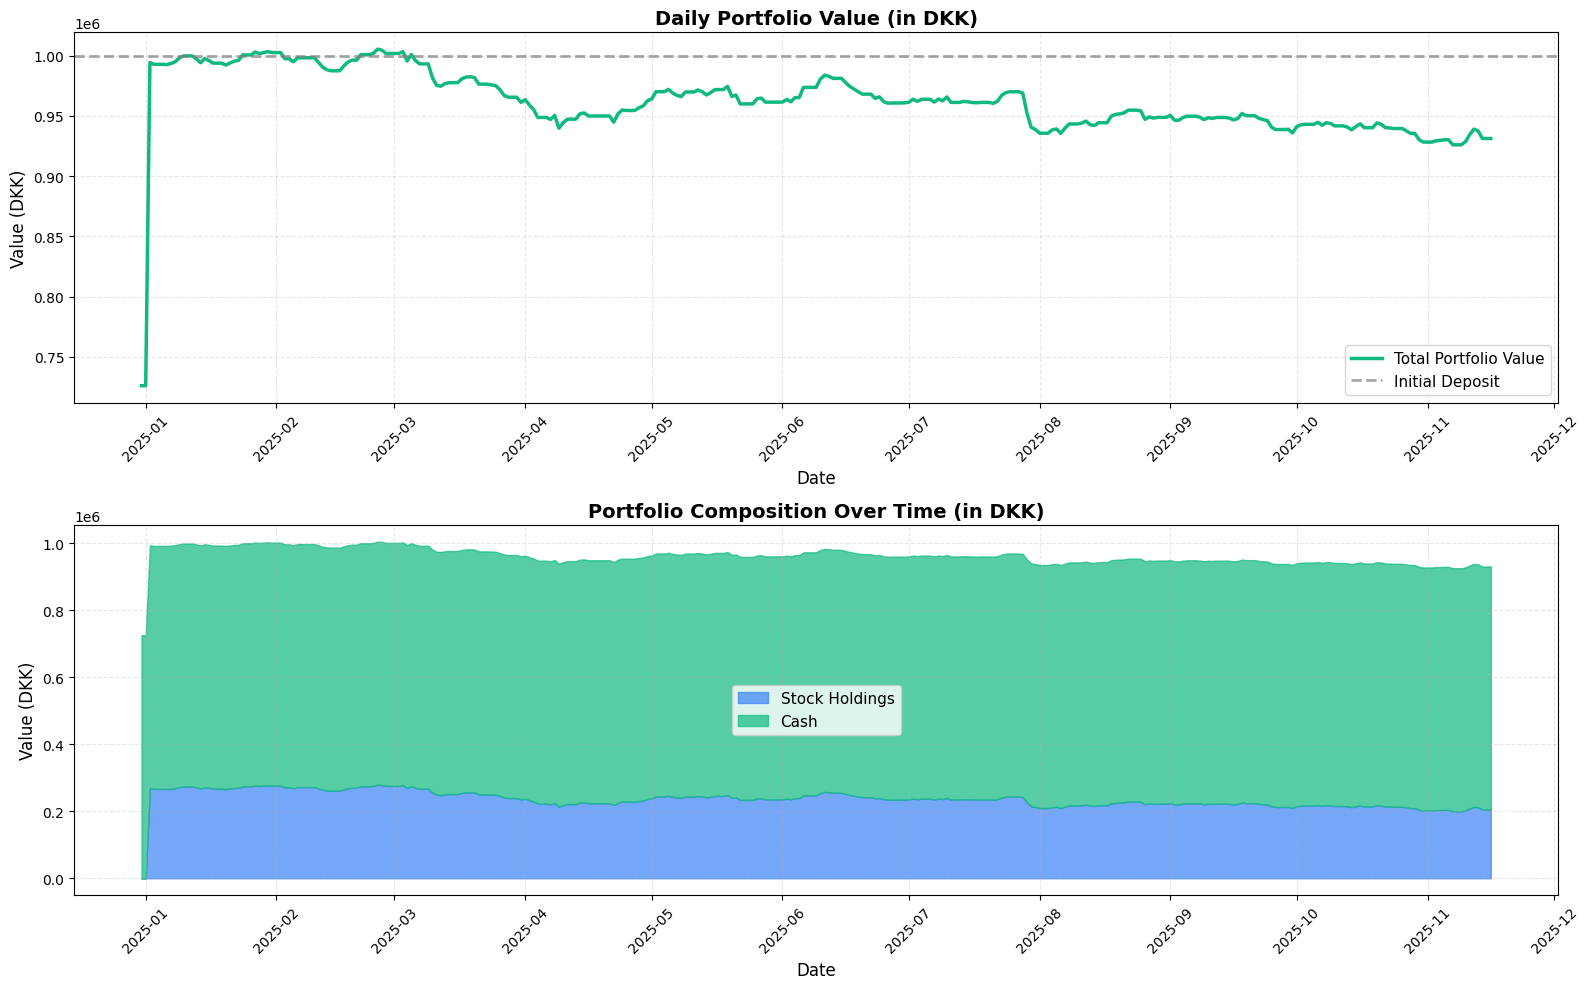


✓ Daily portfolio development charts displayed above


In [46]:
# Cell 12: Daily Portfolio Development
if portfolio_config is None:
    print("Please create a portfolio configuration first (Cell 4)")
elif transactions.empty:
    print("No transactions to analyze")
else:
    print("Calculating daily portfolio development...")
    print("This may take a moment as we fetch historical prices...\n")
    
    # Get date range
    start_date = pd.to_datetime(portfolio_config['start_date'])
    end_date = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))
    
    # Get all unique tickers that have been traded
    all_tickers = transactions[transactions['action'].isin(['buy', 'sell'])]['ticker'].unique()
    
    if len(all_tickers) == 0:
        print("No stock transactions found")
    else:
        # Fetch historical prices
        print("Fetching historical prices...")
        historical_prices = get_historical_prices(all_tickers, start_date)
        
        # Create date range
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        daily_values = []
        
        for current_date in date_range:
            date_str = current_date.strftime('%Y-%m-%d')
            
            # Localize current_date to match historical prices timezone
            current_date_tz = current_date.tz_localize('America/New_York')
            
            # Get holdings at this date
            holdings = calculate_holdings_at_date(transactions, date_str)
            
            # Calculate portfolio value
            stock_value = 0
            
            for ticker, holding in holdings.items():
                if ticker in historical_prices and historical_prices[ticker] is not None:
                    # Get price for this date or closest previous date
                    ticker_prices = historical_prices[ticker]
                    available_dates = ticker_prices.index[ticker_prices.index <= current_date_tz]
                    
                    if len(available_dates) > 0:
                        price_date = available_dates[-1]
                        price = ticker_prices[price_date]
                        
                        rate = get_exchange_rate(holding['currency'])
                        value_dkk = holding['quantity'] * price * rate
                        stock_value += value_dkk
            
            # Calculate cash at this date
            transactions_to_date = transactions[pd.to_datetime(transactions['date']) <= current_date]
            if len(transactions_to_date) > 0:
                # Recalculate cash for this specific date
                rate = get_exchange_rate(portfolio_config['currency'])
                cash = portfolio_config['initial_deposit'] * rate
                
                for _, row in transactions_to_date.iterrows():
                    trans_rate = get_exchange_rate(row['currency'])
                    transaction_fee = row.get('transaction_fee', 0)
                    fx_fee = row.get('fx_fee', 0)
                    
                    if pd.isna(transaction_fee):
                        transaction_fee = 0
                    if pd.isna(fx_fee):
                        fx_fee = 0
                    
                    if row['action'] == 'buy':
                        total_cost = row['quantity'] * row['price'] * trans_rate
                        cash -= total_cost + transaction_fee + fx_fee
                    elif row['action'] == 'sell':
                        total_proceeds = row['quantity'] * row['price'] * trans_rate
                        cash += total_proceeds - transaction_fee - fx_fee
                    elif row['action'] == 'dividend':
                        dividend_amt = row.get('dividend_amount', 0)
                        if pd.notna(dividend_amt):
                            cash += dividend_amt * trans_rate
            else:
                rate = get_exchange_rate(portfolio_config['currency'])
                cash = portfolio_config['initial_deposit'] * rate
            
            total_value = stock_value + cash
            
            daily_values.append({
                'date': current_date,
                'stock_value': stock_value,
                'cash': cash,
                'total_value': total_value
            })
        
        daily_df = pd.DataFrame(daily_values)
        
        print(f"\n✓ Calculated {len(daily_df)} days of portfolio data")
        print("\nLatest portfolio values:")
        display(daily_df.tail(10))
        
        # Plot daily development
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
        
        # Plot 1: Total portfolio value
        ax1.plot(daily_df['date'], daily_df['total_value'], linewidth=2.5, 
                label='Total Portfolio Value', color='#10b981', marker='')
        
        # Add initial deposit line
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        ax1.axhline(y=initial_deposit_dkk, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.7, label='Initial Deposit')
        
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'Value ({BASE_CURRENCY})', fontsize=12)
        ax1.set_title(f'Daily Portfolio Value (in {BASE_CURRENCY})', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot 2: Breakdown - Stocks vs Cash
        ax2.fill_between(daily_df['date'], 0, daily_df['stock_value'], 
                        label='Stock Holdings', alpha=0.7, color='#3b82f6')
        ax2.fill_between(daily_df['date'], daily_df['stock_value'], 
                        daily_df['total_value'], 
                        label='Cash', alpha=0.7, color='#10b981')
        
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel(f'Value ({BASE_CURRENCY})', fontsize=12)
        ax2.set_title(f'Portfolio Composition Over Time (in {BASE_CURRENCY})', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Daily portfolio development charts displayed above")


In [51]:
# Cell 13: Risk Metrics Visualization
if 'daily_df' not in locals() or 'benchmark_return' not in daily_df.columns:
    print("Please run Cell 12 first to calculate portfolio and benchmark data")
else:
    print("Generating risk analysis charts...")
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Cumulative Returns Comparison
    ax1 = plt.subplot(3, 2, 1)
    portfolio_cumulative = (1 + daily_df['daily_return'].fillna(0)).cumprod() - 1
    benchmark_cumulative = (1 + daily_df['benchmark_return'].fillna(0)).cumprod() - 1
    
    ax1.plot(daily_df['date'], portfolio_cumulative * 100, label='Portfolio', linewidth=2, color='#10b981')
    ax1.plot(daily_df['date'], benchmark_cumulative * 100, label='Benchmark', linewidth=2, color='#6366f1', linestyle='--')
    ax1.set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Return (%)', fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Rolling Beta (30-day window)
    ax2 = plt.subplot(3, 2, 2)
    rolling_window = 30
    rolling_cov = daily_df['daily_return'].rolling(window=rolling_window).cov(daily_df['benchmark_return'])
    rolling_var = daily_df['benchmark_return'].rolling(window=rolling_window).var()
    rolling_beta = rolling_cov / rolling_var
    
    ax2.plot(daily_df['date'], rolling_beta, linewidth=2, color='#f59e0b')
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Beta = 1')
    ax2.set_title(f'Rolling Beta ({rolling_window}-day window)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Beta', fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Rolling Sharpe Ratio (30-day window)
    ax3 = plt.subplot(3, 2, 3)
    rolling_excess_returns = daily_df['daily_return'] - (RISK_FREE_RATE / 252)
    rolling_sharpe = (rolling_excess_returns.rolling(window=rolling_window).mean() / 
                     rolling_excess_returns.rolling(window=rolling_window).std()) * np.sqrt(252)
    
    ax3.plot(daily_df['date'], rolling_sharpe, linewidth=2, color='#8b5cf6')
    ax3.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Sharpe = 0')
    ax3.set_title(f'Rolling Sharpe Ratio ({rolling_window}-day window)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Sharpe Ratio', fontsize=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Scatter plot: Portfolio vs Benchmark Returns
    ax4 = plt.subplot(3, 2, 4)
    returns_df = pd.DataFrame({
        'portfolio': daily_df['daily_return'].dropna(),
        'benchmark': daily_df['benchmark_return'].dropna()
    }).dropna()
    
    ax4.scatter(returns_df['benchmark'] * 100, returns_df['portfolio'] * 100, 
               alpha=0.5, s=20, color='#3b82f6')
    
    # Add regression line
    if len(returns_df) > 0:
        z = np.polyfit(returns_df['benchmark'], returns_df['portfolio'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(returns_df['benchmark'].min(), returns_df['benchmark'].max(), 100)
        ax4.plot(x_line * 100, p(x_line) * 100, "r--", linewidth=2, 
                label=f'β = {z[0]:.2f}')
    
    ax4.set_xlabel('Benchmark Daily Return (%)', fontsize=10)
    ax4.set_ylabel('Portfolio Daily Return (%)', fontsize=10)
    ax4.set_title('Portfolio vs Benchmark Returns (Beta)', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linewidth=0.5)
    ax4.axvline(x=0, color='black', linewidth=0.5)
    
    # 5. Volatility Comparison (Rolling Std)
    ax5 = plt.subplot(3, 2, 5)
    portfolio_volatility = daily_df['daily_return'].rolling(window=rolling_window).std() * np.sqrt(252) * 100
    benchmark_volatility = daily_df['benchmark_return'].rolling(window=rolling_window).std() * np.sqrt(252) * 100
    
    ax5.plot(daily_df['date'], portfolio_volatility, label='Portfolio', linewidth=2, color='#10b981')
    ax5.plot(daily_df['date'], benchmark_volatility, label='Benchmark', linewidth=2, color='#6366f1')
    ax5.set_title(f'Rolling Volatility ({rolling_window}-day, annualized)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Volatility (%)', fontsize=10)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Drawdown Analysis
    ax6 = plt.subplot(3, 2, 6)
    cumulative_value = daily_df['total_value']
    running_max = cumulative_value.expanding().max()
    drawdown = ((cumulative_value - running_max) / running_max) * 100
    
    ax6.fill_between(daily_df['date'], drawdown, 0, alpha=0.3, color='red')
    ax6.plot(daily_df['date'], drawdown, linewidth=2, color='red')
    ax6.set_title('Portfolio Drawdown', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Drawdown (%)', fontsize=10)
    ax6.grid(True, alpha=0.3)
    ax6.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate additional statistics
    max_drawdown = drawdown.min()
    current_drawdown = drawdown.iloc[-1]
    
    print(f"\n{'='*80}")
    print(f"📉 DRAWDOWN ANALYSIS")
    print(f"{'='*80}")
    print(f"Maximum Drawdown:        {max_drawdown:.2f}%")
    print(f"Current Drawdown:        {current_drawdown:.2f}%")
    print(f"{'='*80}")
    
    print("\n✓ Risk metrics visualization completed")


Please run Cell 12 first to calculate portfolio and benchmark data


📊 Analyzing individual stock performance over portfolio lifetime...

Fetching historical data for 3 stocks from 2024-12-31 to 2025-11-16...
  ✓ NOVO-B.CO: 220 days of data
  ✓ DEMANT.CO: 220 days of data
  ✓ STG.CO: 220 days of data


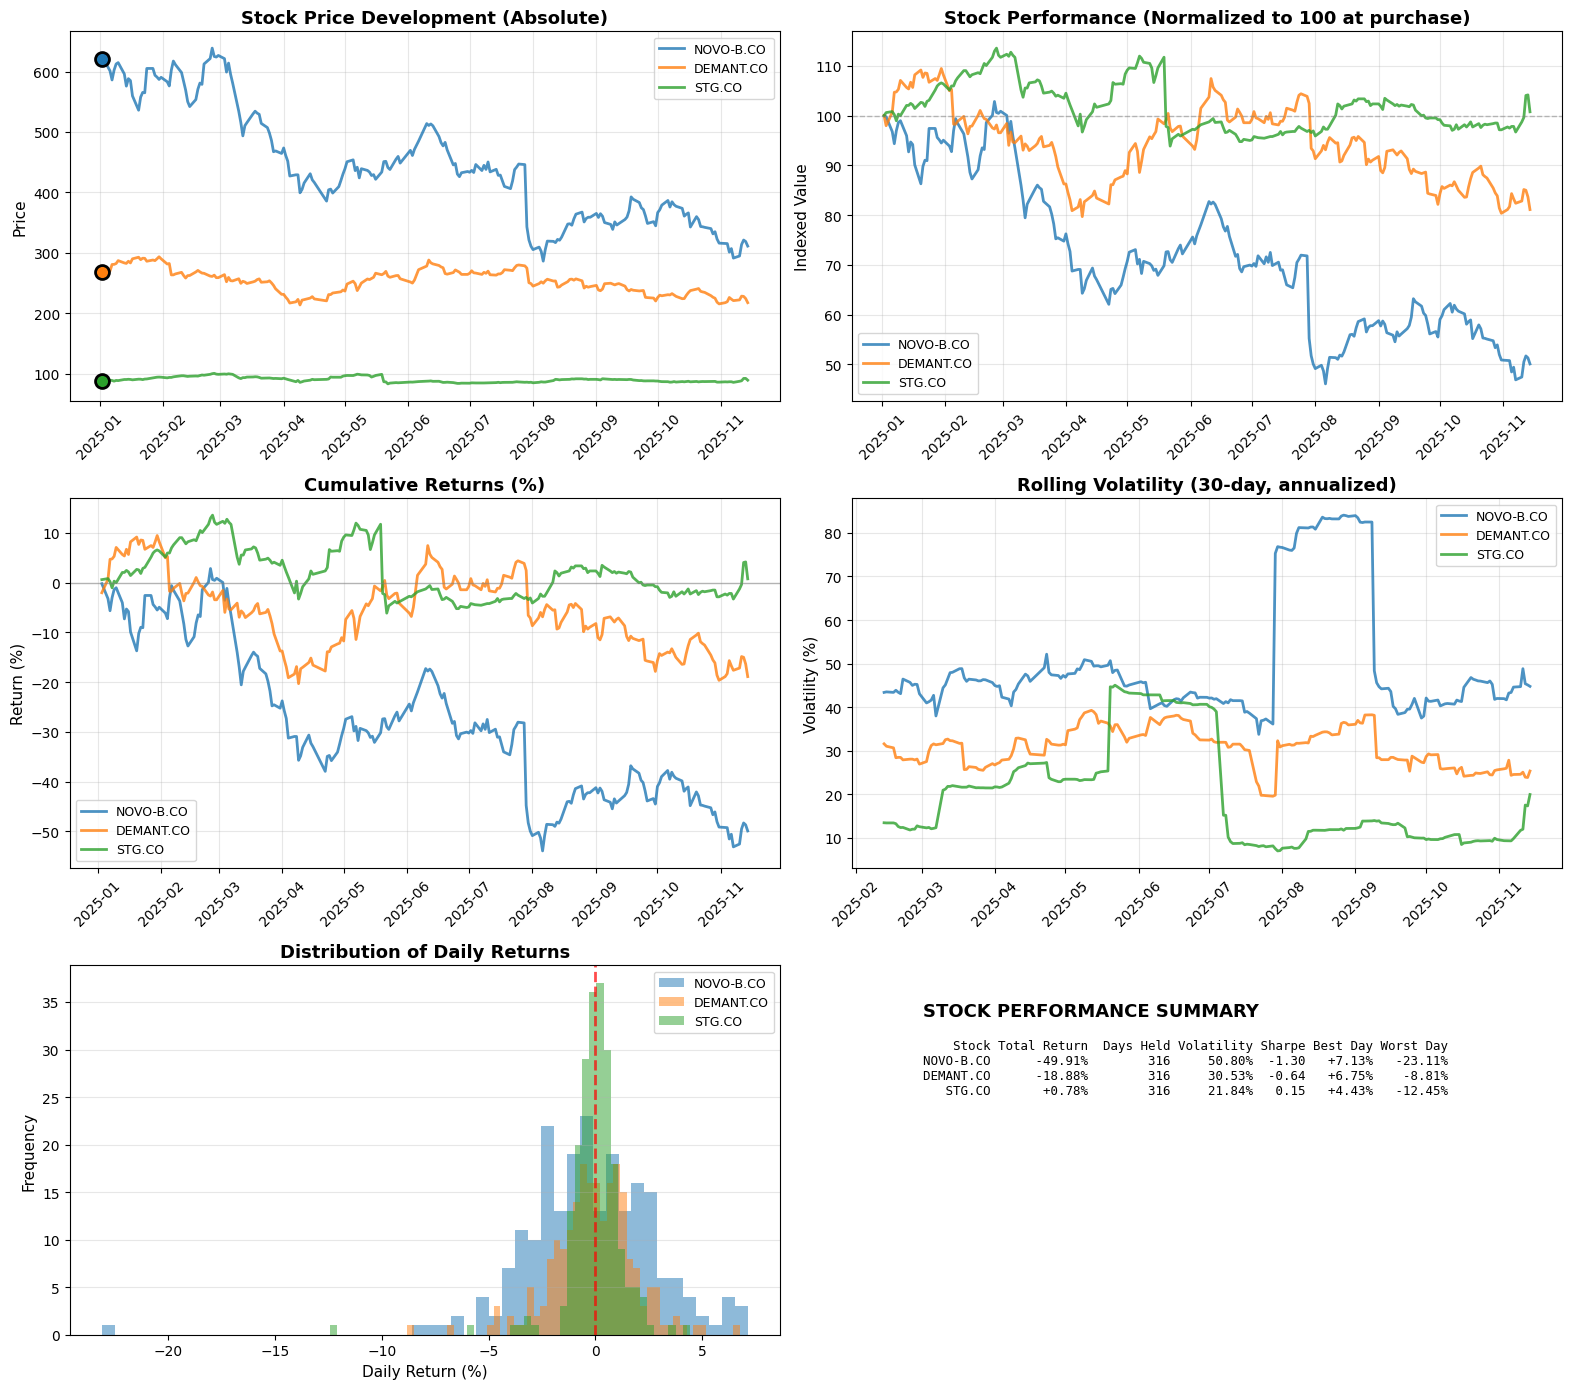


✓ Individual stock performance analysis completed

📈 DETAILED STOCK PERFORMANCE METRICS



,Stock,Total Return,Days Held,Volatility,Sharpe,Best Day,Worst Day
0,NOVO-B.CO,-49.91%,316,50.80%,-1.30,+7.13%,-23.11%
1,DEMANT.CO,-18.88%,316,30.53%,-0.64,+6.75%,-8.81%
2,STG.CO,+0.78%,316,21.84%,0.15,+4.43%,-12.45%


In [48]:
# Cell 14: Individual Stock Performance Analysis
if portfolio_config is None or transactions.empty:
    print("Please create portfolio and add transactions first")
else:
    print("📊 Analyzing individual stock performance over portfolio lifetime...\n")
    
    # Get all stocks that have been traded
    all_stocks = transactions[transactions['action'].isin(['buy', 'sell'])]['ticker'].unique()
    
    if len(all_stocks) == 0:
        print("No stock transactions found")
    else:
        start_date = pd.to_datetime(portfolio_config['start_date'])
        end_date = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))
        
        print(f"Fetching historical data for {len(all_stocks)} stocks from {start_date.date()} to {end_date.date()}...")
        
        stock_data = {}
        stock_first_purchase = {}
        
        # Find first purchase date for each stock
        for stock in all_stocks:
            stock_transactions = transactions[transactions['ticker'] == stock]
            first_buy = stock_transactions[stock_transactions['action'] == 'buy']['date'].min()
            if pd.notna(first_buy):
                stock_first_purchase[stock] = pd.to_datetime(first_buy)
        
        # Fetch historical prices
        for stock in all_stocks:
            try:
                ticker_obj = yf.Ticker(stock)
                hist = ticker_obj.history(start=start_date, end=end_date)
                
                if not hist.empty:
                    stock_data[stock] = hist['Close']
                    print(f"  ✓ {stock}: {len(hist)} days of data")
                else:
                    print(f"  ⚠ {stock}: No data available")
            except Exception as e:
                print(f"  ✗ {stock}: Error - {e}")
        
        if stock_data:
            # Create comprehensive visualization
            fig = plt.figure(figsize=(16, 14))
            
            # 1. Absolute Price Performance
            ax1 = plt.subplot(3, 2, 1)
            colors = plt.cm.tab10(range(len(stock_data)))
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                ax1.plot(prices.index, prices.values, label=stock, linewidth=2, color=colors[i], alpha=0.8)
                
                # Mark first purchase date
                if stock in stock_first_purchase:
                    first_date = stock_first_purchase[stock]
                    # Find closest date in price data
                    # Localize first_date to match prices index timezone
                    if prices.index.tz is not None:
                        first_date_tz = first_date.tz_localize(prices.index.tz)
                    else:
                        first_date_tz = first_date
                    closest_date = prices.index[prices.index >= first_date_tz][0] if any(prices.index >= first_date_tz) else None
                    if closest_date is not None:
                        price_at_purchase = prices[closest_date]
                        ax1.scatter(closest_date, price_at_purchase, color=colors[i], s=100, 
                                   marker='o', edgecolors='black', linewidth=2, zorder=5)
            
            ax1.set_title('Stock Price Development (Absolute)', fontsize=13, fontweight='bold')
            ax1.set_ylabel('Price', fontsize=11)
            ax1.legend(loc='best', fontsize=9)
            ax1.grid(True, alpha=0.3)
            ax1.tick_params(axis='x', rotation=45)
            
            # 2. Normalized Performance (all start at 100)
            ax2 = plt.subplot(3, 2, 2)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                # Normalize to 100 at portfolio start or first purchase
                if stock in stock_first_purchase:
                    first_date = stock_first_purchase[stock]
                    # Localize first_date to match prices index timezone
                    if prices.index.tz is not None:
                        first_date_tz = first_date.tz_localize(prices.index.tz)
                    else:
                        first_date_tz = first_date
                    start_idx = prices.index >= first_date_tz
                    if start_idx.any():
                        normalized_prices = prices[start_idx]
                        normalized = (normalized_prices / normalized_prices.iloc[0]) * 100
                        ax2.plot(normalized.index, normalized.values, label=stock, 
                                linewidth=2, color=colors[i], alpha=0.8)
                else:
                    normalized = (prices / prices.iloc[0]) * 100
                    ax2.plot(normalized.index, normalized.values, label=stock, 
                            linewidth=2, color=colors[i], alpha=0.8)
            
            ax2.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)
            ax2.set_title('Stock Performance (Normalized to 100 at purchase)', fontsize=13, fontweight='bold')
            ax2.set_ylabel('Indexed Value', fontsize=11)
            ax2.legend(loc='best', fontsize=9)
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)
            
            # 3. Cumulative Returns
            ax3 = plt.subplot(3, 2, 3)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                returns = prices.pct_change()
                cumulative_returns = (1 + returns).cumprod() - 1
                ax3.plot(cumulative_returns.index, cumulative_returns.values * 100, 
                        label=stock, linewidth=2, color=colors[i], alpha=0.8)
            
            ax3.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
            ax3.set_title('Cumulative Returns (%)', fontsize=13, fontweight='bold')
            ax3.set_ylabel('Return (%)', fontsize=11)
            ax3.legend(loc='best', fontsize=9)
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
            
            # 4. Rolling Volatility (30-day)
            ax4 = plt.subplot(3, 2, 4)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                returns = prices.pct_change()
                rolling_vol = returns.rolling(window=30).std() * np.sqrt(252) * 100
                ax4.plot(rolling_vol.index, rolling_vol.values, label=stock, 
                        linewidth=2, color=colors[i], alpha=0.8)
            
            ax4.set_title('Rolling Volatility (30-day, annualized)', fontsize=13, fontweight='bold')
            ax4.set_ylabel('Volatility (%)', fontsize=11)
            ax4.legend(loc='best', fontsize=9)
            ax4.grid(True, alpha=0.3)
            ax4.tick_params(axis='x', rotation=45)
            
            # 5. Distribution of Daily Returns
            ax5 = plt.subplot(3, 2, 5)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                returns = prices.pct_change().dropna() * 100
                ax5.hist(returns, bins=50, alpha=0.5, label=stock, color=colors[i])
            
            ax5.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
            ax5.set_title('Distribution of Daily Returns', fontsize=13, fontweight='bold')
            ax5.set_xlabel('Daily Return (%)', fontsize=11)
            ax5.set_ylabel('Frequency', fontsize=11)
            ax5.legend(loc='best', fontsize=9)
            ax5.grid(True, alpha=0.3, axis='y')
            
            # 6. Performance Summary Table (as text in plot)
            ax6 = plt.subplot(3, 2, 6)
            ax6.axis('off')
            
            # Calculate performance metrics for each stock
            performance_data = []
            
            for stock, prices in stock_data.items():
                returns = prices.pct_change().dropna()
                
                # Total return from first purchase
                if stock in stock_first_purchase:
                    first_date = stock_first_purchase[stock]
                    # Localize first_date to match prices index timezone
                    if prices.index.tz is not None:
                        first_date_tz = first_date.tz_localize(prices.index.tz)
                    else:
                        first_date_tz = first_date
                    start_idx = prices.index >= first_date_tz
                    if start_idx.any():
                        relevant_prices = prices[start_idx]
                        total_return = ((relevant_prices.iloc[-1] / relevant_prices.iloc[0]) - 1) * 100
                        days_held = (relevant_prices.index[-1] - relevant_prices.index[0]).days
                    else:
                        total_return = 0
                        days_held = 0
                else:
                    total_return = ((prices.iloc[-1] / prices.iloc[0]) - 1) * 100
                    days_held = (prices.index[-1] - prices.index[0]).days
                
                volatility = returns.std() * np.sqrt(252) * 100
                sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
                
                # Best and worst day
                best_day = returns.max() * 100
                worst_day = returns.min() * 100
                
                performance_data.append({
                    'Stock': stock,
                    'Total Return': f"{total_return:+.2f}%",
                    'Days Held': days_held,
                    'Volatility': f"{volatility:.2f}%",
                    'Sharpe': f"{sharpe:.2f}",
                    'Best Day': f"{best_day:+.2f}%",
                    'Worst Day': f"{worst_day:+.2f}%"
                })
            
            perf_df = pd.DataFrame(performance_data)
            
            # Create table
            table_text = perf_df.to_string(index=False)
            ax6.text(0.1, 0.9, 'STOCK PERFORMANCE SUMMARY', 
                    fontsize=13, fontweight='bold', verticalalignment='top')
            ax6.text(0.1, 0.8, table_text, 
                    fontsize=9, verticalalignment='top', family='monospace')
            
            plt.tight_layout()
            plt.show()
            
            print("\n✓ Individual stock performance analysis completed")
            
            # Print detailed performance table
            print(f"\n{'='*100}")
            print(f"📈 DETAILED STOCK PERFORMANCE METRICS")
            print(f"{'='*100}\n")
            display(perf_df)
        else:
            print("\n⚠ No stock data available for analysis")



In [50]:
# Cell 15: Portfolio Statistics Table (by Week/Month)
if portfolio_config is None or 'daily_df' not in locals():
    print("Please run Cell 12 first to calculate daily portfolio values")
else:
    print("📊 Portfolio Performance Summary\n")
    
    # Weekly summary
    daily_df['week'] = daily_df['date'].dt.to_period('W')
    weekly_df = daily_df.groupby('week').agg({
        'total_value': 'last',
        'stock_value': 'last',
        'cash': 'last'
    }).reset_index()
    weekly_df['week'] = weekly_df['week'].astype(str)
    
    # Calculate weekly returns
    weekly_df['return'] = weekly_df['total_value'].pct_change() * 100
    weekly_df['return'] = weekly_df['return'].fillna(0)
    
    print("📅 Weekly Portfolio Values (Last 10 weeks):")
    display(weekly_df.tail(10))
    
    # Monthly summary
    daily_df['month'] = daily_df['date'].dt.to_period('M')
    monthly_df = daily_df.groupby('month').agg({
        'total_value': 'last',
        'stock_value': 'last',
        'cash': 'last'
    }).reset_index()
    monthly_df['month'] = monthly_df['month'].astype(str)
    
    # Calculate monthly returns
    monthly_df['return'] = monthly_df['total_value'].pct_change() * 100
    monthly_df['return'] = monthly_df['return'].fillna(0)
    
    print("\n📅 Monthly Portfolio Values:")
    display(monthly_df)
    
    # Overall statistics
    rate = get_exchange_rate(portfolio_config['currency'])
    initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
    final_value = daily_df['total_value'].iloc[-1]
    total_return = final_value - initial_deposit_dkk
    total_return_pct = (total_return / initial_deposit_dkk * 100)
    
    # Calculate number of days
    num_days = (daily_df['date'].iloc[-1] - daily_df['date'].iloc[0]).days
    annualized_return = (((final_value / initial_deposit_dkk) ** (365 / num_days)) - 1) * 100 if num_days > 0 else 0
    
    print(f"\n{'='*80}")
    print(f"📈 OVERALL PERFORMANCE STATISTICS")
    print(f"{'='*80}")
    print(f"Start Date:               {portfolio_config['start_date']}")
    print(f"Days Active:              {num_days}")
    print(f"Initial Deposit:          {initial_deposit_dkk:,.2f} {BASE_CURRENCY}")
    print(f"Current Value:            {final_value:,.2f} {BASE_CURRENCY}")
    print(f"Total Return:             {total_return:+,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)")
    print(f"Annualized Return:        {annualized_return:+.2f}%")
    print(f"{'='*80}")


📊 Portfolio Performance Summary

📅 Weekly Portfolio Values (Last 10 weeks):


,week,total_value,stock_value,cash,return
36,2025-09-08/2025-09-14,948697.001068,222690.001068,726007.0,-0.109714
37,2025-09-15/2025-09-21,950147.002365,224140.002365,726007.0,0.152841
38,2025-09-22/2025-09-28,938654.001038,212647.001038,726007.0,-1.209602
39,2025-09-29/2025-10-05,942991.499054,216984.499054,726007.0,0.462098
40,2025-10-06/2025-10-12,941701.502869,215694.502869,726007.0,-0.136798
41,2025-10-13/2025-10-19,940200.498459,214193.498459,726007.0,-0.159393
42,2025-10-20/2025-10-26,939478.001740,213471.001740,726007.0,-0.076845
43,2025-10-27/2025-11-02,928240.501205,202233.501205,726007.0,-1.196143
44,2025-11-03/2025-11-09,925984.002869,199977.002869,726007.0,-0.243094
45,2025-11-10/2025-11-16,931225.494644,205218.494644,726007.0,0.566046



📅 Monthly Portfolio Values:


,month,total_value,stock_value,cash,return
0,2024-12,7.260070e+05,0.000000,726007.0,0.000000
1,2025-01,1.002517e+06,276509.685516,726007.0,38.086366
2,2025-02,1.001827e+06,275819.830933,726007.0,-0.068812
3,2025-03,9.611987e+05,235191.656036,726007.0,-4.055409
4,2025-04,9.625838e+05,236576.781158,726007.0,0.144104
5,2025-05,9.613981e+05,235391.125183,726007.0,-0.123174
6,2025-06,9.608130e+05,234805.984192,726007.0,-0.060864
7,2025-07,9.387118e+05,212704.828033,726007.0,-2.300256
8,2025-08,9.487620e+05,222754.998169,726007.0,1.070634
9,2025-09,9.358875e+05,209880.495148,726007.0,-1.356979



📈 OVERALL PERFORMANCE STATISTICS
Start Date:               2024-12-31
Days Active:              320
Initial Deposit:          1,000,000.00 DKK
Current Value:            931,225.49 DKK
Total Return:             -68,774.51 DKK (-6.88%)
Annualized Return:        -7.81%


In [37]:
# Cell 16: Export Daily Portfolio Data
if 'daily_df' in locals():
    # Export to CSV
    daily_df.to_csv('daily_portfolio_values.csv', index=False)
    print("✓ Daily portfolio values exported to 'daily_portfolio_values.csv'")
    
    # Create detailed report
    report_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    with open('portfolio_report_detailed.txt', 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write(f"DETAILED PORTFOLIO REPORT\n")
        f.write(f"Generated: {report_date}\n")
        f.write(f"Base Currency: {BASE_CURRENCY}\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Portfolio Configuration:\n")
        f.write(f"  Start Date: {portfolio_config['start_date']}\n")
        f.write(f"  Initial Deposit: {portfolio_config['initial_deposit']} {portfolio_config['currency']}\n\n")
        
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        final_value = daily_df['total_value'].iloc[-1]
        total_return = final_value - initial_deposit_dkk
        total_return_pct = (total_return / initial_deposit_dkk * 100)
        
        f.write(f"Current Portfolio Status:\n")
        f.write(f"  Total Value: {final_value:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Stock Holdings: {daily_df['stock_value'].iloc[-1]:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Cash: {daily_df['cash'].iloc[-1]:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Total Return: {total_return:+,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)\n\n")
        
        f.write("="*80 + "\n")
        f.write("TRANSACTION HISTORY\n")
        f.write("="*80 + "\n")
        f.write(transactions.to_string(index=False))
        f.write("\n\n")
        
        f.write("="*80 + "\n")
        f.write("MONTHLY PERFORMANCE\n")
        f.write("="*80 + "\n")
        f.write(monthly_df.to_string(index=False))
    
    print("✓ Detailed portfolio report exported to 'portfolio_report_detailed.txt'")
else:
    print("Please run Cell 12 first to generate portfolio data")


✓ Daily portfolio values exported to 'daily_portfolio_values.csv'
✓ Detailed portfolio report exported to 'portfolio_report_detailed.txt'


In [52]:
# Cell 17: Portfolio Risk Metrics Summary. Bemørk at denne celle er tilføjet separat efter en snak med Claude.
if 'daily_df' not in locals() or 'benchmark_return' not in daily_df.columns:
    print("Please run Cell 12 first to calculate portfolio and benchmark data")
else:
    print("📊 Calculating comprehensive risk metrics...\n")
    
    # Calculate metrics
    alpha, beta, sharpe_ratio, correlation = calculate_portfolio_metrics(
        daily_df['daily_return'].dropna(),
        daily_df['benchmark_return'].dropna(),
        RISK_FREE_RATE
    )
    
    if alpha is not None:
        # Calculate additional metrics
        daily_returns = daily_df['daily_return'].dropna()
        
        # Portfolio statistics
        portfolio_return_annual = daily_returns.mean() * 252 * 100
        portfolio_volatility_annual = daily_returns.std() * np.sqrt(252) * 100
        
        # Benchmark statistics
        benchmark_returns = daily_df['benchmark_return'].dropna()
        benchmark_return_annual = benchmark_returns.mean() * 252 * 100
        benchmark_volatility_annual = benchmark_returns.std() * np.sqrt(252) * 100
        
        # Downside deviation (for Sortino Ratio)
        negative_returns = daily_returns[daily_returns < 0]
        downside_deviation = negative_returns.std() * np.sqrt(252) * 100
        sortino_ratio = ((daily_returns.mean() * 252 - RISK_FREE_RATE) / (negative_returns.std() * np.sqrt(252))) if len(negative_returns) > 0 and negative_returns.std() > 0 else 0
        
        # Information Ratio
        active_returns = daily_returns - benchmark_returns
        information_ratio = (active_returns.mean() / active_returns.std()) * np.sqrt(252) if active_returns.std() > 0 else 0
        
        # Maximum Drawdown
        cumulative_returns = (1 + daily_returns).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        
        # Calmar Ratio (Return / Max Drawdown)
        calmar_ratio = (portfolio_return_annual / abs(max_drawdown)) if max_drawdown != 0 else 0
        
        # Create summary dataframe
        metrics_data = {
            'Metric': [
                'Annual Return',
                'Annual Volatility',
                'Sharpe Ratio',
                'Sortino Ratio',
                'Alpha (α)',
                'Beta (β)',
                'Information Ratio',
                'Correlation with Benchmark',
                'Maximum Drawdown',
                'Calmar Ratio'
            ],
            'Portfolio': [
                f"{portfolio_return_annual:.2f}%",
                f"{portfolio_volatility_annual:.2f}%",
                f"{sharpe_ratio:.3f}",
                f"{sortino_ratio:.3f}",
                f"{alpha*100:.2f}%",
                f"{beta:.3f}",
                f"{information_ratio:.3f}",
                f"{correlation:.3f}",
                f"{max_drawdown:.2f}%",
                f"{calmar_ratio:.3f}"
            ],
            'Benchmark': [
                f"{benchmark_return_annual:.2f}%",
                f"{benchmark_volatility_annual:.2f}%",
                '-',
                '-',
                '-',
                '1.000',
                '-',
                '-',
                '-',
                '-'
            ]
        }
        
        metrics_df = pd.DataFrame(metrics_data)
        
        print(f"{'='*100}")
        print(f"📈 COMPREHENSIVE RISK-ADJUSTED PERFORMANCE METRICS")
        print(f"{'='*100}")
        print(f"Benchmark: {BENCHMARK_TICKER}")
        print(f"Risk-Free Rate: {RISK_FREE_RATE*100:.1f}%")
        print(f"Analysis Period: {daily_df['date'].min().date()} to {daily_df['date'].max().date()}")
        print(f"Number of Trading Days: {len(daily_returns)}")
        print(f"{'='*100}\n")
        
        display(metrics_df)
        
        print(f"\n{'='*100}")
        print(f"📚 METRIC INTERPRETATIONS")
        print(f"{'='*100}")
        
        print(f"\n🎯 RETURN METRICS:")
        print(f"  • Annual Return: {portfolio_return_annual:.2f}% vs Benchmark {benchmark_return_annual:.2f}%")
        print(f"    → You are {'OUTPERFORMING' if portfolio_return_annual > benchmark_return_annual else 'UNDERPERFORMING'} the benchmark by {abs(portfolio_return_annual - benchmark_return_annual):.2f}%")
        
        print(f"\n📊 RISK METRICS:")
        print(f"  • Annual Volatility: {portfolio_volatility_annual:.2f}% vs Benchmark {benchmark_volatility_annual:.2f}%")
        print(f"    → Your portfolio is {'MORE' if portfolio_volatility_annual > benchmark_volatility_annual else 'LESS'} volatile than the benchmark")
        print(f"  • Maximum Drawdown: {max_drawdown:.2f}%")
        print(f"    → Your worst peak-to-trough decline was {abs(max_drawdown):.2f}%")
        
        print(f"\n💎 RISK-ADJUSTED RETURNS:")
        print(f"  • Sharpe Ratio: {sharpe_ratio:.3f}")
        if sharpe_ratio > 2:
            sharpe_rating = "EXCELLENT - Outstanding risk-adjusted returns"
        elif sharpe_ratio > 1:
            sharpe_rating = "GOOD - Strong risk-adjusted returns"
        elif sharpe_ratio > 0.5:
            sharpe_rating = "ACCEPTABLE - Moderate risk-adjusted returns"
        elif sharpe_ratio > 0:
            sharpe_rating = "POOR - Low risk-adjusted returns"
        else:
            sharpe_rating = "NEGATIVE - Returns below risk-free rate"
        print(f"    → {sharpe_rating}")
        
        print(f"  • Sortino Ratio: {sortino_ratio:.3f}")
        print(f"    → Similar to Sharpe but only penalizes downside volatility")
        print(f"    → {'BETTER' if sortino_ratio > sharpe_ratio else 'SIMILAR'} than Sharpe (focuses on bad volatility)")
        
        print(f"  • Calmar Ratio: {calmar_ratio:.3f}")
        print(f"    → Return per unit of maximum drawdown")
        print(f"    → {'GOOD' if calmar_ratio > 0.5 else 'NEEDS IMPROVEMENT'} - Higher is better")
        
        print(f"\n🎲 MARKET RELATIONSHIP:")
        print(f"  • Alpha (α): {alpha*100:.2f}%")
        if alpha > 0.02:
            alpha_rating = "EXCELLENT - Significantly beating the market"
        elif alpha > 0:
            alpha_rating = "POSITIVE - Adding value above market returns"
        elif alpha > -0.02:
            alpha_rating = "NEUTRAL - Performing similar to market"
        else:
            alpha_rating = "NEGATIVE - Underperforming the market"
        print(f"    → {alpha_rating}")
        
        print(f"  • Beta (β): {beta:.3f}")
        if beta > 1.2:
            beta_rating = "HIGH - Much more volatile than market (high risk/reward)"
        elif beta > 0.8:
            beta_rating = "MODERATE - Similar volatility to market"
        elif beta > 0.5:
            beta_rating = "LOW - Less volatile than market (defensive)"
        else:
            beta_rating = "VERY LOW - Minimal correlation with market movements"
        print(f"    → {beta_rating}")
        
        print(f"  • Correlation: {correlation:.3f}")
        if abs(correlation) > 0.8:
            corr_rating = "VERY HIGH - Moves closely with benchmark"
        elif abs(correlation) > 0.5:
            corr_rating = "MODERATE - Some independent movement"
        else:
            corr_rating = "LOW - Largely independent of benchmark"
        print(f"    → {corr_rating}")
        
        print(f"  • Information Ratio: {information_ratio:.3f}")
        if information_ratio > 0.5:
            ir_rating = "GOOD - Consistent outperformance"
        elif information_ratio > 0:
            ir_rating = "POSITIVE - Some consistent alpha generation"
        else:
            ir_rating = "NEGATIVE - Inconsistent vs benchmark"
        print(f"    → {ir_rating}")
        
        print(f"\n{'='*100}")
        print(f"✅ OVERALL ASSESSMENT:")
        
        # Overall score
        score = 0
        if alpha > 0: score += 1
        if sharpe_ratio > 1: score += 1
        if sortino_ratio > 1: score += 1
        if information_ratio > 0: score += 1
        if max_drawdown > -20: score += 1
        
        if score >= 4:
            overall = "STRONG PERFORMANCE - Portfolio is performing well across multiple metrics"
        elif score >= 3:
            overall = "GOOD PERFORMANCE - Portfolio is solid with room for improvement"
        elif score >= 2:
            overall = "MODERATE PERFORMANCE - Consider reviewing strategy"
        else:
            overall = "NEEDS IMPROVEMENT - Multiple metrics suggest underperformance"
        
        print(f"  {overall}")
        print(f"  Score: {score}/5 metrics in good range")
        print(f"{'='*100}\n")
        
    else:
        print("⚠ Not enough data to calculate comprehensive risk metrics (need at least 30 days)")


Please run Cell 12 first to calculate portfolio and benchmark data
